In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import akshare as ak
from datetime import date, timedelta
from financial_calculator import *
from fundresearch import *
import seaborn as sns

from fund_tools import *
from AIP import *

![jupyter](./framework.png)

In [2]:
# Set date variable

today = date.today()
first_day_of_the_week = today - timedelta(days=today.weekday())
# end = start + timedelta(days=6)
print("Today: " + str(today))
print("Start: " + str(first_day_of_the_week))
# print("End: " + str(end))

Today: 2022-01-24
Start: 2022-01-24


In [3]:
stock_zh_index_spot_df = ak.stock_zh_index_spot()[['代码','名称']]
stock_zh_index_spot_df

100%|██████████| 8/8 [00:02<00:00,  3.40it/s]


,代码,名称
0,sh000001,上证指数
1,sh000002,Ａ股指数
2,sh000003,Ｂ股指数
3,sh000004,工业指数
4,sh000005,商业指数
...,...,...
583,sz988006,
584,sz988007,
585,sz988106,
586,sz988107,


- 中欧量化驱动基准指数：$创业板指数收益率 \times 95\% + 中债综合指数收益率 \times 5\%$
- 没有找到中债综合指数，暂用沪深300

In [4]:
start_date = pd.to_datetime('2018-05-16')
end_date = pd.to_datetime(date.today())

# 沪深300，创业板指数，中证500
HS300_index = ak.stock_zh_index_daily(symbol="sh000300")[['date', 'close']]
CY_index = ak.stock_zh_index_daily(symbol="sz399006")[['date', 'close']]
ZZ500_index = ak.stock_zh_index_daily(symbol="sh000905")[['date', 'close']]

fund_value = get_fund_net_worth('001980', start_date=start_date, end_date=end_date, fund_category='open')


100%|██████████| 8/8 [00:01<00:00,  4.13it/s]


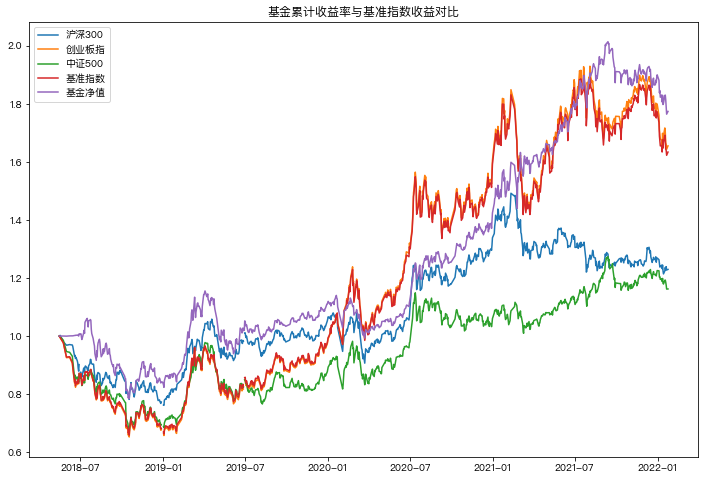

In [5]:
comp_df = fund_vs_benchmark('001980', ['sh000300', 'sz399006', 'sh000905'], '2018-05-16', end_date, PLOT=True)

Text(0.5, 1.0, '基金收益率对比指数')

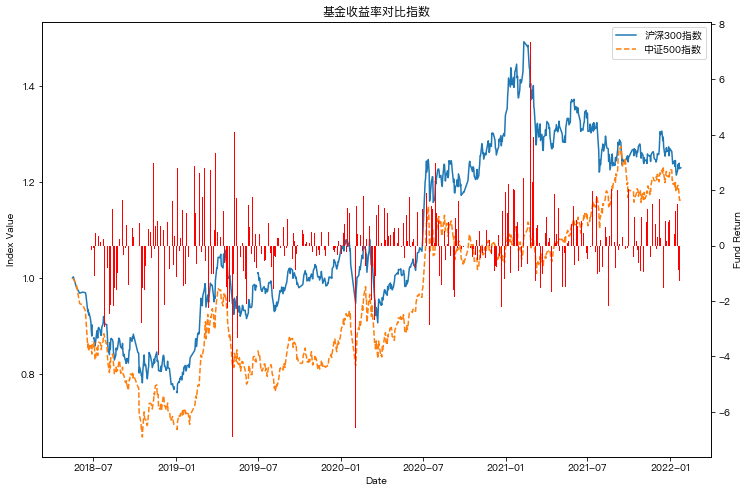

In [6]:
fig,ax = plt.subplots(figsize=(12,8))

ax.plot(comp_df.index, comp_df['sh000300'], label='沪深300指数')
ax.plot(comp_df.index, comp_df['sh000905'], '--',label='中证500指数')

ax.set_xlabel('Date')
ax.set_ylabel('Index Value')
ax.legend()
ax2 = ax.twinx()
ax2.bar(comp_df.index, comp_df['日增长率'], color='r')
ax2.set_ylabel('Fund Return')
ax.set_title('基金收益率对比指数')

In [7]:
comp_df['基金日收益率'] = (comp_df['单位净值']/comp_df['单位净值'].shift() - 1)*100
comp_df['沪深300收益率'] = (comp_df['sh000300']/comp_df['sh000300'].shift() - 1)*100
comp_df['创业板指收益率'] = (comp_df['sz399006']/comp_df['sz399006'].shift() - 1)*100
comp_df['中证500收益率'] = (comp_df['sh000905']/comp_df['sh000905'].shift() - 1)*100
comp_df.dropna(inplace=True)

In [8]:
comp_df

,单位净值,日增长率,sh000300,sz399006,sh000905,基准指数,基金日收益率,沪深300收益率,创业板指收益率,中证500收益率
净值日期,,,,,,,,,,
2018-05-18,1.0002,0.00,1.002625,0.994628,0.998514,0.995028,0.020000,0.262533,-0.537236,-0.148566
2018-05-25,1.0003,0.00,0.980388,0.977188,0.985631,0.977348,0.009998,-2.217899,-1.753365,-1.290243
2018-06-01,0.9999,0.00,0.968595,0.925744,0.946877,0.927886,-0.039988,-1.202909,-5.264529,-3.931902
2018-06-08,1.0008,0.00,0.970914,0.926813,0.944243,0.929018,0.090009,0.239406,0.115469,-0.278147
2018-06-14,1.0009,0.00,0.969308,0.906125,0.930524,0.909284,0.009992,-0.165361,-2.232107,-1.452948
...,...,...,...,...,...,...,...,...,...,...
2022-01-18,1.8300,0.07,1.236460,1.702700,1.193051,1.679388,0.065617,0.966401,-0.822449,0.074044
2022-01-19,1.8140,-0.87,1.227991,1.665684,1.185656,1.643799,-0.874317,-0.684950,-2.173943,-0.619796
2022-01-20,1.7867,-1.50,1.239071,1.660278,1.175334,1.639218,-1.504961,0.902251,-0.324547,-0.870615


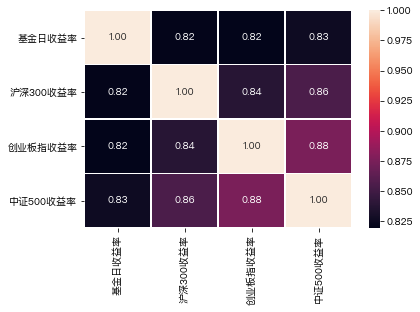

In [9]:
sns.heatmap(comp_df[['基金日收益率', '沪深300收益率', '创业板指收益率', '中证500收益率']].corr(),linewidths=.5, annot=True, fmt=".2f")

In [10]:
fund_value = fund_value.reset_index()

fund_value['year'] = pd.DatetimeIndex(fund_value['净值日期']).year
fund_value['month'] = pd.DatetimeIndex(fund_value['净值日期']).month
fund_value

,index,净值日期,单位净值,日增长率,year,month
0,0,2018-05-16,1.0000,0.00,2018,5
1,1,2018-05-18,1.0002,0.00,2018,5
2,2,2018-05-25,1.0003,0.00,2018,5
3,3,2018-06-01,0.9999,0.00,2018,6
4,4,2018-06-08,1.0008,0.00,2018,6
...,...,...,...,...,...,...
883,883,2022-01-18,1.8300,0.07,2022,1
884,884,2022-01-19,1.8140,-0.87,2022,1
885,885,2022-01-20,1.7867,-1.50,2022,1
886,886,2022-01-21,1.7642,-1.26,2022,1


In [11]:
year_list = fund_value['year'].unique()

performance_df = pd.DataFrame()
for year in year_list:
    sub_df = fund_value[fund_value['year'] == year]

    metrics_list = [return_metrics(sub_df)[0], return_metrics(sub_df)[1], risk_metrics(sub_df)[0],
                    risk_metrics(sub_df)[1], sharpe(sub_df), calmar(sub_df)]

    performance_df[year] = metrics_list

performance_df['全区间'] = [return_metrics(fund_value)[0], return_metrics(fund_value)[1], risk_metrics(fund_value)[0],
                    risk_metrics(fund_value)[1], sharpe(fund_value), calmar(fund_value)]

performance_df.index = ['Absolute Return', 'Annulized Return', 'Annual Volatility',
                         'Max Drawdown', 'Sharpe Ratio', 'Calmar Ratio']

performance_df = performance_df.transpose()
performance_df


100%|██████████| 17/17 [00:06<00:00,  2.82it/s]


,Absolute Return,Annulized Return,Annual Volatility,Max Drawdown,Sharpe Ratio,Calmar Ratio
2018,-0.158200,-0.263331,24.440238,-0.260792,-1.124232,1.009738
2019,0.334134,0.345168,21.898399,-0.187089,1.030550,-1.844943
2020,0.272240,0.283636,17.441925,-0.128925,1.121712,-2.200015
2021,0.303933,0.316813,20.263625,-0.099650,1.176091,-3.179264
2022,-0.056891,-0.626198,18.225534,-0.061995,-1.609275,10.100792
全区间,0.773800,0.176617,20.739095,-0.260792,0.952701,-0.677234


In [12]:
comp_df.reset_index(inplace=True)
HS300_df = comp_df[['净值日期','sh000300']]
CYZH_df = comp_df[['净值日期', 'sz399006']]
ZZ500_df = comp_df[['净值日期', 'sh000905']]
JZZH_df = comp_df[['净值日期', '基准指数']]

HS300_df.columns = ['净值日期', '单位净值']
CYZH_df.columns = ['净值日期', '单位净值']
JZZH_df.columns = ['净值日期', '单位净值']
ZZ500_df.columns = ['净值日期', '单位净值']

HS300_df = daily_return(HS300_df)
CYZH_df = daily_return(CYZH_df)
JZZH_df = daily_return(JZZH_df)
ZZ500_df = daily_return(ZZ500_df)

In [13]:
comp_stat_df = pd.DataFrame()

comp_stat_df['中欧量化'] = [return_metrics(fund_value)[0], return_metrics(fund_value)[1], risk_metrics(fund_value)[0],
                    risk_metrics(fund_value)[1], sharpe(fund_value), calmar(fund_value)]
comp_stat_df['沪深300'] = [return_metrics(HS300_df)[0], return_metrics(HS300_df)[1], risk_metrics(HS300_df)[0],
                    risk_metrics(HS300_df)[1], sharpe(HS300_df), calmar(HS300_df)]
comp_stat_df['创业板指'] = [return_metrics(CYZH_df)[0], return_metrics(CYZH_df)[1], risk_metrics(CYZH_df)[0],
                    risk_metrics(CYZH_df)[1], sharpe(CYZH_df), calmar(CYZH_df)]
comp_stat_df['中证500'] = [return_metrics(ZZ500_df)[0], return_metrics(ZZ500_df)[1], risk_metrics(ZZ500_df)[0],
                    risk_metrics(ZZ500_df)[1], sharpe(ZZ500_df), calmar(ZZ500_df)]
comp_stat_df['基准指数'] = [return_metrics(JZZH_df)[0], return_metrics(JZZH_df)[1], risk_metrics(JZZH_df)[0],
                    risk_metrics(JZZH_df)[1], sharpe(JZZH_df), calmar(JZZH_df)]

comp_stat_df.index = ['Absolute Return', 'Annulized Return', 'Annual Volatility',
                         'Max Drawdown', 'Sharpe Ratio', 'Calmar Ratio']

comp_stat_df = comp_stat_df.transpose()
comp_stat_df

100%|██████████| 17/17 [00:05<00:00,  2.88it/s]


,Absolute Return,Annulized Return,Annual Volatility,Max Drawdown,Sharpe Ratio,Calmar Ratio
中欧量化,0.773800,0.176617,20.739095,-0.260792,0.952701,-0.677234
沪深300,0.226405,0.060114,16.336159,-0.240381,-0.637331,-0.250080
创业板指,0.664041,0.156808,23.195883,-0.343934,0.358139,-0.455925
中证500,0.164149,0.044434,17.843875,-0.329715,-1.122985,-0.134765
基准指数,0.641992,0.152403,22.979423,-0.337690,0.338239,-0.451310


In [14]:
## make three time slots

time_slots = pd.to_datetime(['2021-01-21', '2020-01-21', '2019-01-21'])
columns = ['近一年', '近两年', '近三年']
df_list = [comp_df, JZZH_df, HS300_df, ZZ500_df,CYZH_df]

return_df = pd.DataFrame(index=['中欧量化','基准指数','沪深300','中证500', '创业板指'])

for i in range(len(time_slots)):
    annualreturn = []
    for df in df_list:
        mask =  (df["净值日期"] >= time_slots[i]) & (df["净值日期"] <= end_date)
        df = df.loc[mask]
        annualreturn.append(return_metrics(df)[1]*100)
    return_df[columns[i]] = annualreturn

return_df

,近一年,近两年,近三年
中欧量化,15.609293,26.172484,27.836665
基准指数,-7.406475,24.745831,34.153810
沪深300,-14.353883,8.130728,15.070456
中证500,5.545046,12.835201,17.481419
创业板指,-7.112187,25.556769,35.182869


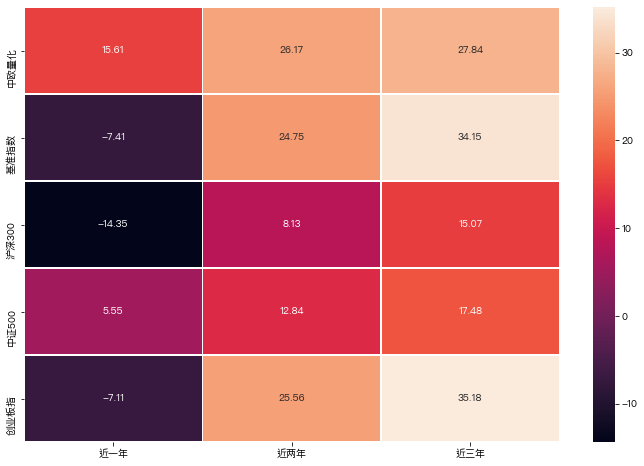

In [15]:
fig = plt.figure(figsize=(12,8))
sns.heatmap(return_df, linewidths=.5, annot=True, fmt=".2f")

In [16]:
monthly_return_df = pd.DataFrame(index=range(2018,2023),columns=range(1,13))

for year in year_list:
    month_list = fund_value[fund_value['year'] == year]['month'].unique()
    for month in month_list:
        df = fund_value[(fund_value['year'] == year) & (fund_value['month'] == month)]
        ret = (df['单位净值'].values[-1]/df['单位净值'].values[0] - 1) * 100
        monthly_return_df.loc[year, month] = ret

monthly_return_df = monthly_return_df.fillna(0.00)

Text(88.0, 0.5, 'Year')

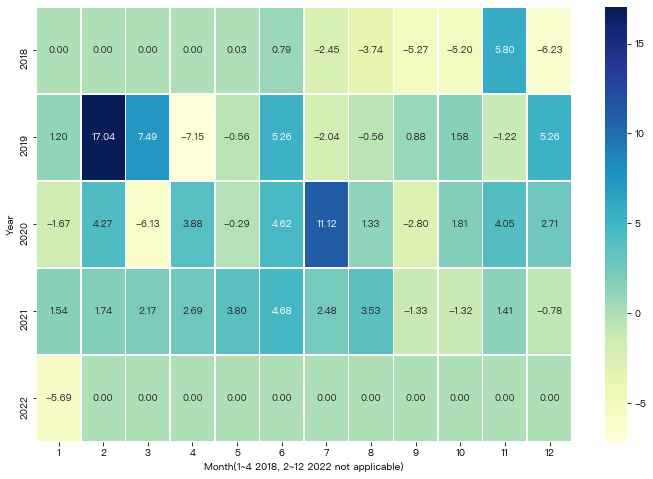

In [17]:
fig = plt.figure(figsize=(12,8))
sns.heatmap(monthly_return_df, linewidths=.5, annot=True, fmt=".2f", cmap="YlGnBu")
plt.xlabel('Month(1~4 2018, 2~12 2022 not applicable)')
plt.ylabel('Year')

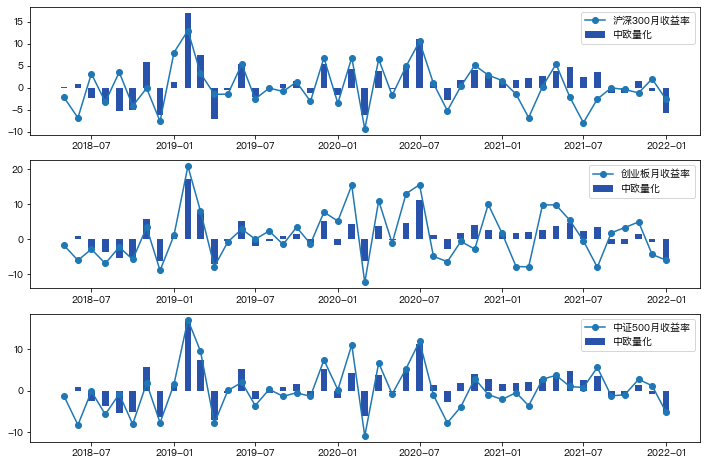

In [18]:
fig = plt.figure(figsize=(12,8))

plt.subplot(3,1,1)
plt.plot(transto_monthlyreturn(HS300_df).index, transto_monthlyreturn(HS300_df), '-o', label='沪深300月收益率')
plt.bar(transto_monthlyreturn(fund_value).index, transto_monthlyreturn(fund_value)['ret'], width=15, color='#2952ab', label='中欧量化')
plt.legend()
plt.subplot(3,1,2)
plt.plot(transto_monthlyreturn(CYZH_df).index, transto_monthlyreturn(CYZH_df), '-o', label='创业板月收益率' )
plt.bar(transto_monthlyreturn(fund_value).index, transto_monthlyreturn(fund_value)['ret'], width=15, color='#2952ab', label='中欧量化')
plt.legend()
plt.subplot(3,1,3)
plt.plot(transto_monthlyreturn(ZZ500_df).index, transto_monthlyreturn(ZZ500_df), '-o', label='中证500月收益率')
plt.bar(transto_monthlyreturn(fund_value).index, transto_monthlyreturn(fund_value)['ret'], width=15, color='#2952ab', label='中欧量化')
plt.legend()


In [19]:
index_monthly_value_df = pd.DataFrame()

index_monthly_value_df['中欧量化'] = transto_monthlyindex(fund_value)['Value']
index_monthly_value_df['沪深300'] = transto_monthlyindex(HS300_df)['Value']
index_monthly_value_df['中证500'] = transto_monthlyindex(ZZ500_df)['Value']
index_monthly_value_df['创业指数'] = transto_monthlyindex(CYZH_df)['Value']

index_monthly_value_df['沪深300/中证500'] = index_monthly_value_df['沪深300']/index_monthly_value_df['中证500']
index_monthly_value_df['沪深300/创业指数'] = index_monthly_value_df['沪深300']/index_monthly_value_df['创业指数']
index_monthly_value_df['创业指数/中证500'] = index_monthly_value_df['创业指数']/index_monthly_value_df['中证500']
index_monthly_value_df.head()

,中欧量化,沪深300,中证500,创业指数,沪深300/中证500,沪深300/创业指数,创业指数/中证500
2018-05-01,1.0003,0.980388,0.985631,0.977188,0.994681,1.003275,0.991434
2018-06-01,1.0078,0.901907,0.869038,0.870058,1.037823,1.036606,1.001174
2018-07-01,0.9822,0.903621,0.864200,0.845443,1.045616,1.068814,0.978295
2018-08-01,0.9376,0.856573,0.801927,0.777181,1.068143,1.102154,0.969142
2018-09-01,0.8922,0.883381,0.799579,0.764260,1.104808,1.155865,0.955828


Text(0.5, 1.0, '基金收益率 大/小盘股切换')

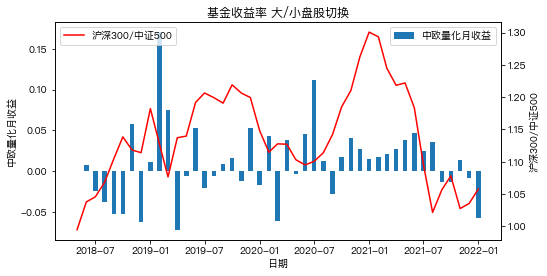

In [20]:
fig,ax = plt.subplots(figsize=(8,4))
ax.bar(transto_monthlyreturn(fund_value).index, transto_monthlyreturn(fund_value)['ret']/100, width=15, label='中欧量化月收益')
ax.set_xlabel('日期')
ax.set_ylabel('中欧量化月收益')
ax.legend()
ax2 = ax.twinx()
ax2.plot(index_monthly_value_df.index, index_monthly_value_df['沪深300/中证500'], color='r', label='沪深300/中证500')
ax2.set_ylabel('沪深300/中证500')
ax2.legend(loc=2)
ax.set_title('基金收益率 大/小盘股切换')

Text(0.5, 1.0, '基金收益率 大盘股/创业板切换')

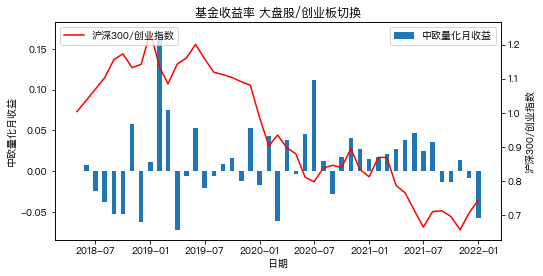

In [21]:
fig,ax = plt.subplots(figsize=(8,4))
ax.bar(transto_monthlyreturn(fund_value).index, transto_monthlyreturn(fund_value)['ret']/100, width=15, label='中欧量化月收益')
ax.set_xlabel('日期')
ax.set_ylabel('中欧量化月收益')
ax.legend()
ax2 = ax.twinx()
ax2.plot(index_monthly_value_df.index, index_monthly_value_df['沪深300/创业指数'], color='r', label='沪深300/创业指数')
ax2.set_ylabel('沪深300/创业指数')
ax2.legend(loc=2)
ax.set_title('基金收益率 大盘股/创业板切换')

Text(0.5, 1.0, '基金收益率 创业板/小盘股切换')

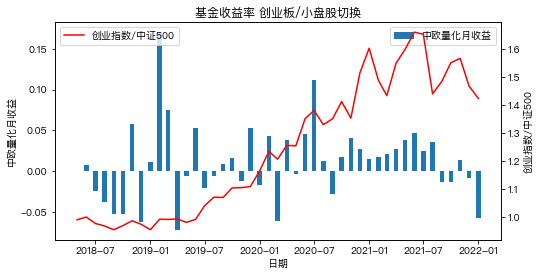

In [22]:
fig,ax = plt.subplots(figsize=(8,4))
ax.bar(transto_monthlyreturn(fund_value).index, transto_monthlyreturn(fund_value)['ret']/100, width=15, label='中欧量化月收益')
ax.set_xlabel('日期')
ax.set_ylabel('中欧量化月收益')
ax.legend()
ax2 = ax.twinx()
ax2.plot(index_monthly_value_df.index, index_monthly_value_df['创业指数/中证500'], color='r', label='创业指数/中证500')
ax2.set_ylabel('创业指数/中证500')
ax2.legend(loc=2)
ax.set_title('基金收益率 创业板/小盘股切换')

In [23]:
## highest return 5 months
## not hard to see the highest returns fall on 2019 Feb, 2020 Jul, 2019 Mar, 2018 Nov, 2019 Jun


## calculate the return without the highest return one by one

return_bar_df = transto_monthlyreturn(fund_value)
losing_index = return_bar_df.sort_values('ret', ascending=False).head().index

ret_result = []
for index in losing_index:
    return_bar_df.loc[index, 'ret'] = 0
    ret_array = return_bar_df.ret/100 + 1
    ret_result.append((np.prod(ret_array) - 1)*100)

ret_result = [comp_stat_df.iloc[0,0]*100] + ret_result
ret_result

[77.38000000000001,
 32.732293378442435,
 19.44843695545981,
 11.127675088630573,
 5.032010298235257,
 -0.2211352594875815]

Text(0.5, 1.0, '错过最高收益累计收益率-衰减比例')

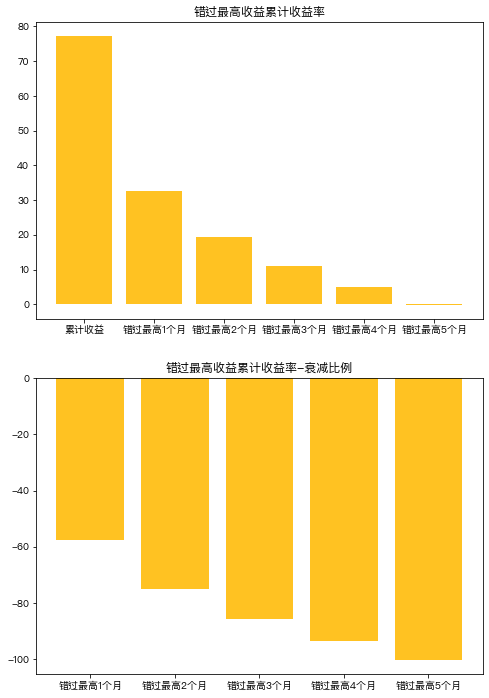

In [24]:
losing_profit_df = pd.DataFrame(index=['累计收益', '错过最高1个月', '错过最高2个月', '错过最高3个月', '错过最高4个月', '错过最高5个月'])

losing_profit_df['收益率'] = ret_result
decay_ratio = (np.array(ret_result[1:])/ret_result[0]-1)*100
decay_profit_df = pd.DataFrame(index=['错过最高1个月', '错过最高2个月', '错过最高3个月', '错过最高4个月', '错过最高5个月'], columns=['收益率'], data=decay_ratio)

fig = plt.figure(figsize=(8,12))
plt.subplot(2,1,1)
plt.bar(losing_profit_df.index, losing_profit_df['收益率'], color='#FFC222')
plt.title('错过最高收益累计收益率')
plt.subplot(2,1,2)
plt.bar(decay_profit_df.index, decay_profit_df['收益率'], color='#FFC222')
plt.title('错过最高收益累计收益率-衰减比例')

Text(0.5, 1.0, '中欧量化vs创业板指')

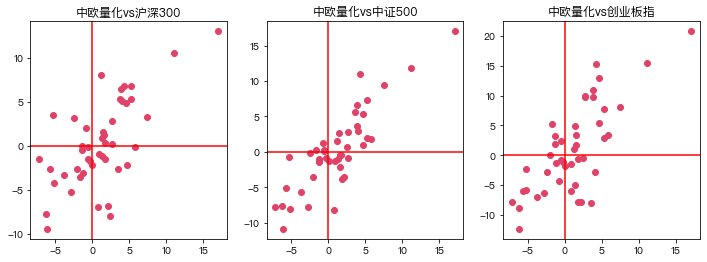

In [25]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.scatter(transto_monthlyreturn(fund_value)['ret'], transto_monthlyreturn(HS300_df)['ret'], color='#e04368')
plt.axhline(0, color='r', linestyle='-')
plt.axvline(0, color='r', linestyle='-')
plt.title('中欧量化vs沪深300')
plt.subplot(1,3,2)
plt.scatter(transto_monthlyreturn(fund_value)['ret'], transto_monthlyreturn(ZZ500_df)['ret'], color='#e04368')
plt.axhline(0, color='r', linestyle='-')
plt.axvline(0, color='r', linestyle='-')
plt.title('中欧量化vs中证500')
plt.subplot(1,3,3)
plt.scatter(transto_monthlyreturn(fund_value)['ret'], transto_monthlyreturn(CYZH_df)['ret'], color='#e04368')
plt.axhline(0, color='r', linestyle='-')
plt.axvline(0, color='r', linestyle='-')
plt.title('中欧量化vs创业板指')


Text(0.5, 1.0, '回撤深水线')

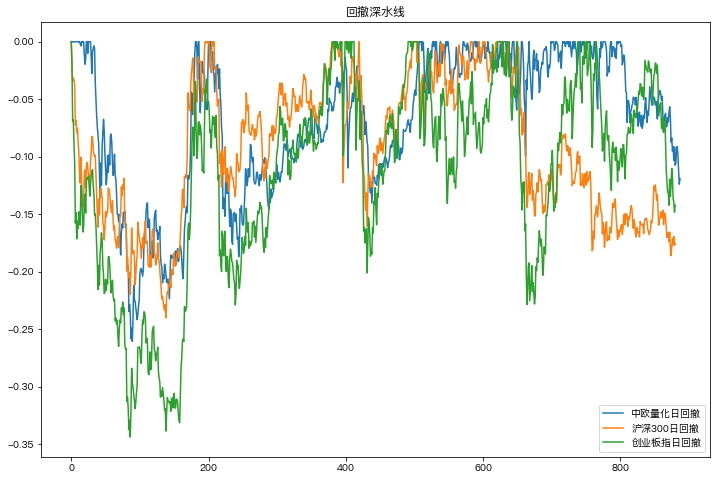

In [26]:
## drawdown analysis

# fund_value = fund_value.set_index('净值日期')
# HS300_df = HS300_df.set_index('净值日期')
# CYZH_df = CYZH_df.set_index('净值日期')

fig = plt.figure(figsize=(12,8))

plt.plot(max_drawdown_df(fund_value, PLOT=False), label='中欧量化日回撤')
plt.plot(max_drawdown_df(HS300_df, PLOT=False), label='沪深300日回撤')
plt.plot(max_drawdown_df(CYZH_df, PLOT=False), label='创业板指日回撤')
plt.legend()
plt.title('回撤深水线')

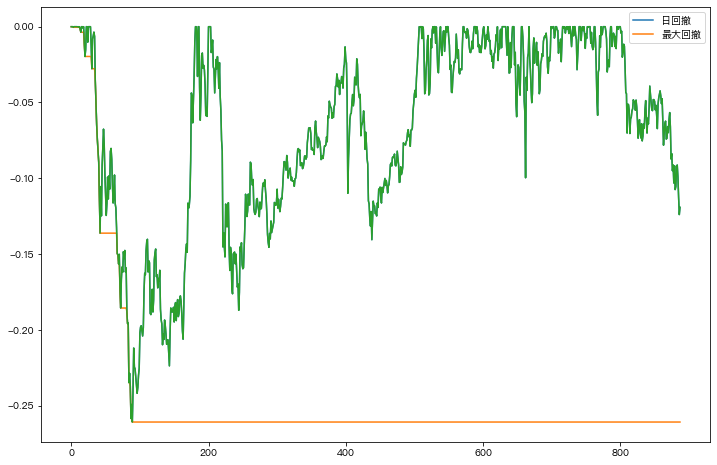

In [27]:
max_drawdown_df(fund_value, PLOT=True).plot()

#### Fund Performance Attribution(against factor models)

In [28]:
import statsmodels.api as sm

capm_df = pd.read_csv('./factor data/CAPM单因子模型.csv').round(6)
ff3f_df = pd.read_csv('./factor data/Fama-French-三因子模型.csv').round(6)
ff5f_df = pd.read_csv('./factor data/Fama-French-五因子模型.csv').round(6)
carhart4_df = pd.read_csv('./factor data/Carhart-四因子模型.csv').round(6)

capm_df['date'] = pd.to_datetime(capm_df['date'])
ff3f_df['date'] = pd.to_datetime(ff3f_df['date'])
ff5f_df['date'] = pd.to_datetime(ff5f_df['date'])
carhart4_df['date'] = pd.to_datetime(carhart4_df['date'])

In [29]:
capm_df

,date,RF,MKT
0,1995-01-03,0.000182,-0.009724
1,1995-01-04,0.000182,0.023004
2,1995-01-05,0.000182,-0.009166
3,1995-01-06,0.000182,-0.007825
4,1995-01-09,0.000182,-0.027512
...,...,...,...
6553,2021-12-27,0.000069,0.000316
6554,2021-12-28,0.000069,0.005397
6555,2021-12-29,0.000069,-0.008921
6556,2021-12-30,0.000069,0.007040


In [30]:
## slice factor data to fit the fund period

start_date = pd.to_datetime('2018-05-16')
end_date = pd.to_datetime('2021-12-31')

mask =  (capm_df["date"] >= start_date) & (capm_df["date"] <= end_date)
capm_df = capm_df.loc[mask].set_index('date').dropna()
mask =  (ff3f_df["date"] >= start_date) & (ff3f_df["date"] <= end_date)
ff3f_df = ff3f_df.loc[mask].set_index('date').dropna()
mask =  (ff5f_df["date"] >= start_date) & (ff5f_df["date"] <= end_date)
ff5f_df = ff5f_df.loc[mask].set_index('date').dropna()
mask =  (carhart4_df["date"] >= start_date) & (carhart4_df["date"] <= end_date)
carhart4_df = carhart4_df.loc[mask].set_index('date').dropna()


In [31]:
fund_value = get_fund_net_worth('001980', start_date=start_date, end_date=end_date, fund_category='open')[['净值日期','单位净值']].set_index('净值日期')
fund_value['ret'] = (fund_value['单位净值']/fund_value['单位净值'].shift())-1
fund_value.dropna(inplace=True)

capm_perform_attr = fund_value.join(capm_df).dropna()
ff3f_perform_attr = fund_value.join(ff3f_df).dropna()
ff5f_perform_attr = fund_value.join(ff5f_df).dropna()
carhart4_perform_attr = fund_value.join(carhart4_df).dropna()

In [32]:
Fund_Perform_Attribution(capm_perform_attr)

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     1135.
Date:                Mon, 24 Jan 2022   Prob (F-statistic):          1.14e-242
Time:                        17:22:41   Log-Likelihood:                 3093.2
No. Observations:                 869   AIC:                            -6180.
Df Residuals:                     866   BIC:                            -6166.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.001     -1.365      0.1

In [33]:
Fund_Perform_Attribution(ff3f_perform_attr)

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     612.3
Date:                Mon, 24 Jan 2022   Prob (F-statistic):          2.12e-250
Time:                        17:22:41   Log-Likelihood:                 3118.2
No. Observations:                 869   AIC:                            -6226.
Df Residuals:                     864   BIC:                            -6203.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0025      0.001     -1.820      0.0

In [34]:
Fund_Perform_Attribution(ff5f_perform_attr)

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     434.4
Date:                Mon, 24 Jan 2022   Prob (F-statistic):          1.36e-256
Time:                        17:22:41   Log-Likelihood:                 3139.1
No. Observations:                 869   AIC:                            -6264.
Df Residuals:                     862   BIC:                            -6231.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0026      0.001     -1.976      0.0

In [35]:
Fund_Perform_Attribution(carhart4_perform_attr)

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     494.4
Date:                Mon, 24 Jan 2022   Prob (F-statistic):          2.07e-250
Time:                        17:22:41   Log-Likelihood:                 3121.5
No. Observations:                 869   AIC:                            -6231.
Df Residuals:                     863   BIC:                            -6202.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0026      0.001     -1.896      0.0

#### Other similar funds comparison

In [95]:
fund_value1 = get_fund_net_worth('001974', start_date=start_date, end_date=end_date, fund_category='open').set_index('净值日期')
fund_value2 = get_fund_net_worth('460009', start_date=start_date, end_date=end_date, fund_category='open').set_index('净值日期')
fund_value3 = get_fund_net_worth('377010', start_date=start_date, end_date=end_date, fund_category='open').set_index('净值日期')
fund_value4 = get_fund_net_worth('000978', start_date=start_date, end_date=end_date, fund_category='open').set_index('净值日期')
fund_value5 = get_fund_net_worth('519983', start_date=start_date, end_date=end_date, fund_category='open').set_index('净值日期')
fund_value6 = get_fund_net_worth('004495', start_date=start_date, end_date=end_date, fund_category='open').set_index('净值日期')
fund_value7 = get_fund_net_worth('519021', start_date=start_date, end_date=end_date, fund_category='open').set_index('净值日期')
fund_value8 = get_fund_net_worth('001143', start_date=start_date, end_date=end_date, fund_category='open').set_index('净值日期')
fund_value9 = get_fund_net_worth('233009', start_date=start_date, end_date=end_date, fund_category='open').set_index('净值日期')
fund_value10 = get_fund_net_worth('005225', start_date=start_date, end_date=end_date, fund_category='open').set_index('净值日期')

fund_value1.rename(columns={'日增长率': '景顺长城量化驱动'}, inplace=True)
fund_value2.rename(columns={'日增长率': '华泰柏瑞量化先行'}, inplace=True)
fund_value3.rename(columns={'日增长率': '上投摩根阿尔法'}, inplace=True)
fund_value4.rename(columns={'日增长率': '景顺长城量化精选'}, inplace=True) 
fund_value5.rename(columns={'日增长率': '长信量化先锋A'}, inplace=True) 
fund_value6.rename(columns={'日增长率': '博时量化平衡'}, inplace=True) 
fund_value7.rename(columns={'日增长率': '国泰金鼎价值精选'}, inplace=True) 
fund_value8.rename(columns={'日增长率': '华商量化进取'}, inplace=True) 
fund_value9.rename(columns={'日增长率': '大摩多因子'}, inplace=True) 
fund_value10.rename(columns={'日增长率': '广发量化多因子'}, inplace=True)

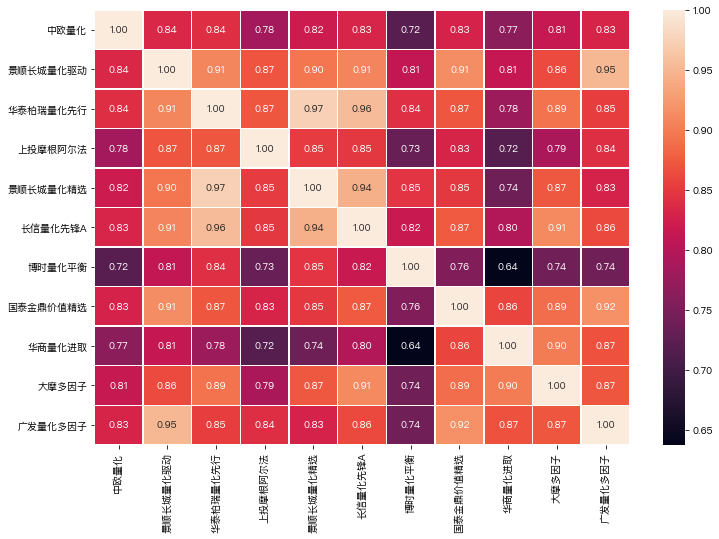

In [97]:
corr_df = pd.DataFrame()

corr_df['中欧量化'] = fund_value['ret']
corr_df = corr_df.join(fund_value1['景顺长城量化驱动'])
corr_df = corr_df.join(fund_value2['华泰柏瑞量化先行'])
corr_df = corr_df.join(fund_value3['上投摩根阿尔法'])
corr_df = corr_df.join(fund_value4['景顺长城量化精选'])
corr_df = corr_df.join(fund_value5['长信量化先锋A'])
corr_df = corr_df.join(fund_value6['博时量化平衡'])
corr_df = corr_df.join(fund_value7['国泰金鼎价值精选'])
corr_df = corr_df.join(fund_value8['华商量化进取'])
corr_df = corr_df.join(fund_value9['大摩多因子'])
corr_df = corr_df.join(fund_value10['广发量化多因子'])


fig = plt.figure(figsize=(12,8))
sns.heatmap(corr_df.corr(), linewidths=.5, annot=True, fmt=".2f")


#### 持有收益体验

TypeError: 'NoneType' object is not subscriptable

In [69]:
fund_value1